---
title: "NumPyroを使ってベイズ回帰モデルの実装"
description: "ベイズ回帰モデルの実装をNumPyroを使って行う"
date: "2025-12-14"
categories: ["統計手法", "ベイズ推論"]
jupyter: python3
---

参照させていただいた記事:  
[【ベイズ統計モデリング入門】NumPyroで回帰モデルをつくる](https://cpp-learning.com/numpyro/)

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import jax.numpy as jnp
from jax import random, vmap, grad, jit, lax

import numpyro
from numpyro import plate, sample
from numpyro.infer import MCMC, NUTS, Predictive
import numpyro.distributions as dist

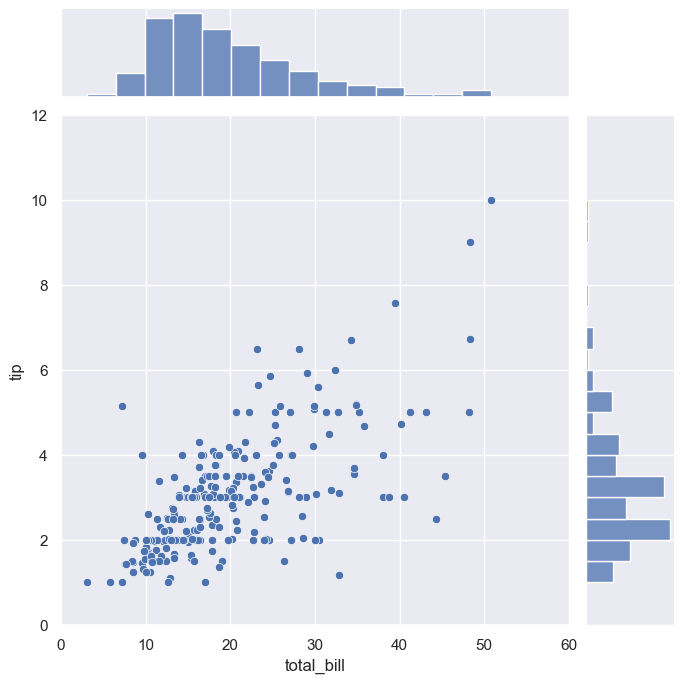

In [4]:
# チップのデータセット
df = sns.load_dataset("tips")

# 会計総額とチップのデータを可視化
sns.set(style="darkgrid")
sns.jointplot(
    x="total_bill",
    y="tip",
    data=df,
    kind="scatter",
    xlim=(0, 60),
    ylim=(0, 12),
    color="b",
    height=7,
)

In [5]:
df.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


## -線形回帰モデル-
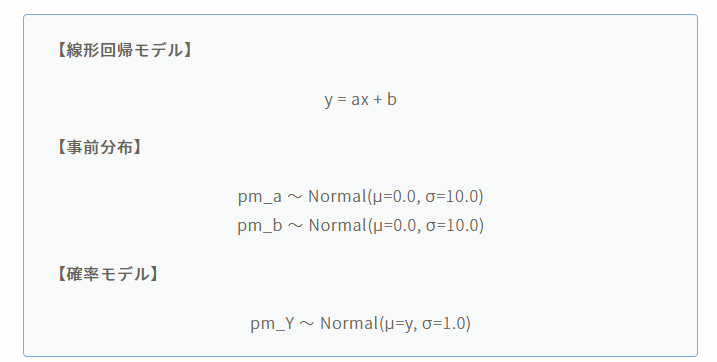

In [7]:
# 線形回帰モデルの設計
def model(X, Y=None):
    pm_a = numpyro.sample("pm_a", dist.Normal(0, 10))
    pm_b = numpyro.sample("pm_b", dist.Normal(0, 10))

    mu = pm_a * X + pm_b
    sigma = 1.0

    pm_Y = numpyro.sample("pm_Y", dist.Normal(mu, sigma), obs=Y)

    return pm_Y

### MCMCの実行

In [ ]:
# dfからnumpy.ndarrayに変換
Y = df["tip"].values  # 目的変数：Y = [y0, y1, y2, ... yi]
X = df["total_bill"].values  # 説明変数：X = [x0, x1, x2, ... xi]

In [13]:
# RUN MCMC
# NUTS (No-U-Turn Sampler) is an adaptive variant of the Hamiltonian Monte Carlo (HMC) algorithm
# HMCのステップサイズや反復回数などのパラメータを自動調整
# 効率的なサンプル
# 収束の改善
# https://qiita.com/dai08srhg/items/5d4ac3070bae836aef10
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000)
mcmc.run(rng_key=random.PRNGKey(0), X=X, Y=Y)

# print MCMC summary（推定パラメータの基本統計量）
mcmc.print_summary()

sample: 100%|██████████| 3000/3000 [00:00<00:00, 3616.90it/s, 11 steps of size 2.54e-01. acc. prob=0.94]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      pm_a      0.11      0.01      0.11      0.09      0.12    368.76      1.00
      pm_b      0.90      0.16      0.90      0.65      1.17    377.02      1.00

Number of divergences: 0


In [15]:
# get param (num_samples=2000)
mcmc_samples = mcmc.get_samples()
pm_a = mcmc_samples["pm_a"]
pm_b = mcmc_samples["pm_b"]

print("mcmc_samples:", mcmc_samples)
print("pm_a:", pm_a)
print("pm_b:", pm_b)

mcmc_samples: {'pm_a': Array([0.10649762, 0.110033  , 0.10530762, ..., 0.11129791, 0.10644959,
       0.10579225], dtype=float32), 'pm_b': Array([0.86267745, 0.9398046 , 0.9131396 , ..., 0.751051  , 0.8998211 ,
       0.8538504 ], dtype=float32)}
pm_a: [0.10649762 0.110033   0.10530762 ... 0.11129791 0.10644959 0.10579225]
pm_b: [0.86267745 0.9398046  0.9131396  ... 0.751051   0.8998211  0.8538504 ]


In [25]:
len(set(pm_a.tolist()))

1971

C:\Users\takuk\AppData\Local\Temp\ipykernel_27764\3318693772.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pm_a)
C:\Users\takuk\AppData\Local\Temp\ipykernel_27764\3318693772.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pm_b)


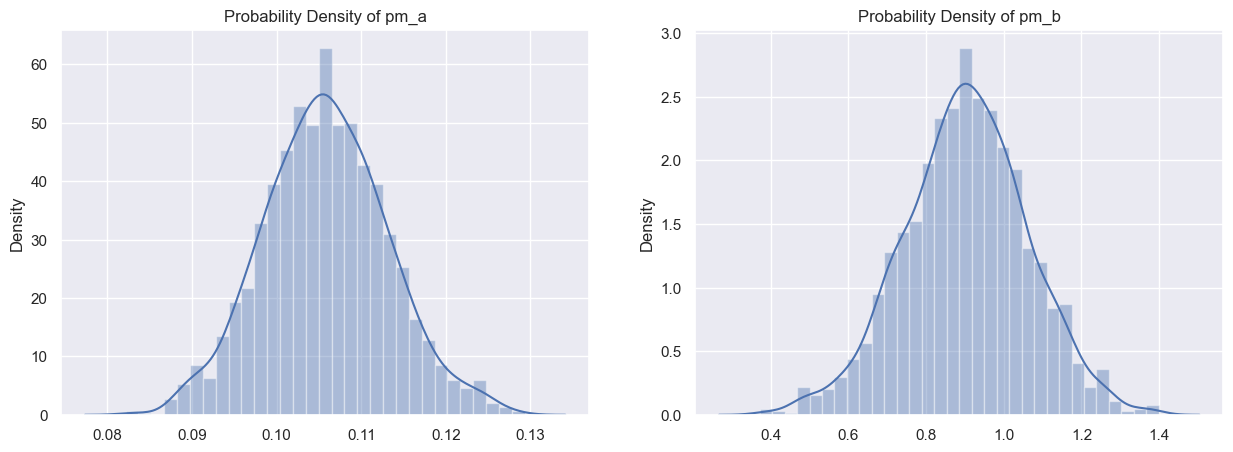

In [16]:
# 可視化
sns.set(style="darkgrid")
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.distplot(pm_a)
plt.title("Probability Density of pm_a")

plt.subplot(1, 2, 2)
sns.distplot(pm_b)
plt.title("Probability Density of pm_b")
plt.show()

In [ ]:
X_range = jnp.linspace(0, 50, 51)

predictive = Predictive(model, mcmc_samples)
predict_samples = predictive(random.PRNGKey(1), X=X_range, Y=None)
print(predict_samples)

{'pm_Y': Array([[ 1.810429  ,  0.02438818,  0.22200845, ...,  5.2724934 ,
         6.715812  ,  6.422859  ],
       [ 0.15076251,  0.8095171 ,  0.21540537, ...,  5.2437186 ,
         7.817451  ,  6.173345  ],
       [ 2.476837  ,  0.21040367,  0.42815638, ...,  8.04783   ,
         7.40407   ,  5.8891115 ],
       ...,
       [ 1.0230944 ,  1.1552314 ,  0.25326768, ...,  4.831621  ,
         7.0255423 ,  5.759563  ],
       [ 1.5060548 , -0.62601656,  1.4508446 , ...,  5.9778643 ,
         6.058488  ,  4.774219  ],
       [ 1.0496006 ,  0.51519567,  1.4674567 , ...,  5.349556  ,
         4.992259  ,  6.651703  ]], dtype=float32)}


In [30]:
pm_Y = predict_samples["pm_Y"]
print(pm_Y)

[[ 1.810429    0.02438818  0.22200845 ...  5.2724934   6.715812
   6.422859  ]
 [ 0.15076251  0.8095171   0.21540537 ...  5.2437186   7.817451
   6.173345  ]
 [ 2.476837    0.21040367  0.42815638 ...  8.04783     7.40407
   5.8891115 ]
 ...
 [ 1.0230944   1.1552314   0.25326768 ...  4.831621    7.0255423
   5.759563  ]
 [ 1.5060548  -0.62601656  1.4508446  ...  5.9778643   6.058488
   4.774219  ]
 [ 1.0496006   0.51519567  1.4674567  ...  5.349556    4.992259
   6.651703  ]]


In [31]:
len(pm_Y)

2000

### 推論

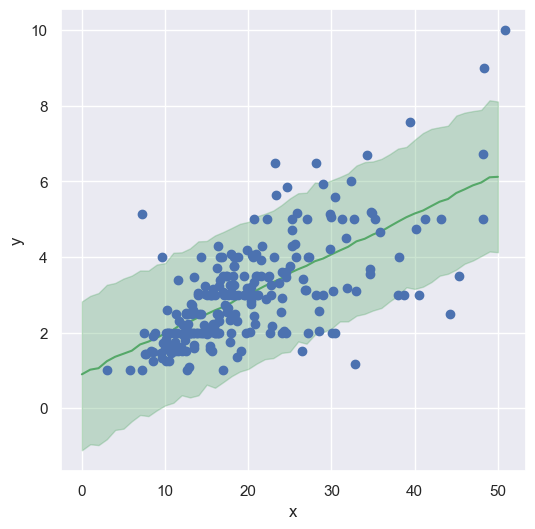

In [35]:
mean_Y = pm_Y.mean(axis=0)
y_low, y_high = jnp.percentile(pm_Y, jnp.array([2.5, 97.5]), axis=0)

# 可視化
fig = plt.figure(figsize=(6.0, 6.0))
plt.plot(X_range, mean_Y, "-", color="g")
plt.fill_between(X_range, y_low, y_high, color="g", alpha=0.3)
plt.plot(X, Y, "o")
plt.xlabel("x"), plt.ylabel("y")
plt.show()

### 全てのパラメターを使って推論

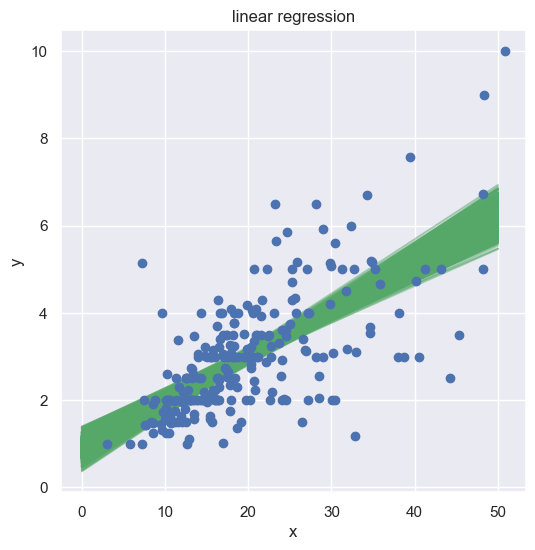

In [36]:
N = len(pm_a)
# X_range = jnp.linspace(0, 50, 50)

# 予測結果の可視化
fig = plt.figure(figsize=(6.0, 6.0))
for i in range(N):
    pm_y = [pm_a[i] * x + pm_b[i] for x in X_range]
    plt.plot(X_range, pm_y, "g-", alpha=0.5)

# データセットの可視化
plt.plot(X, Y, "o")
plt.xlabel("x"), plt.ylabel("y")
plt.title("linear regression")
plt.show()

In [ ]:
def my_model(mcmc_samples, X):
    """線形回帰モデル"""
    mcmc_samples = mcmc.get_samples()
    pm_a = mcmc_samples["pm_a"]
    pm_b = mcmc_samples["pm_b"]

    # 平均値
    mu_a = jnp.mean(pm_a, axis=0)
    mu_b = jnp.mean(pm_b, axis=0)
    print("mu_a=", mu_a)
    print("mu_b=", mu_b)

    # 線形回帰モデル
    Y_hat = mu_a * X + mu_b

    return Y_hat

mu_a= 0.10581156
mu_b= 0.9027909


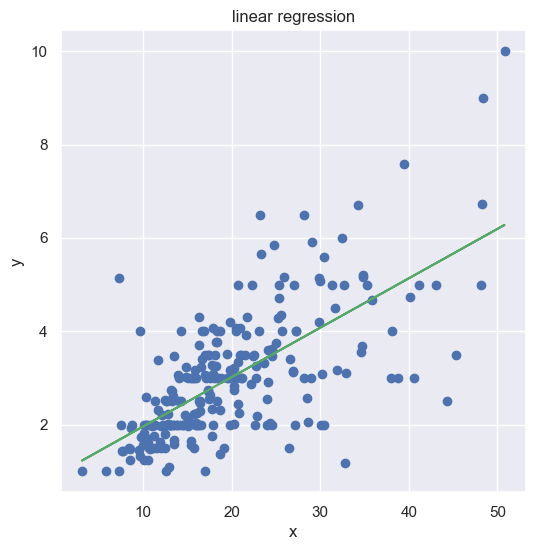

In [ ]:
# 予測値
Y_hat = my_model(mcmc_samples, X)

# 可視化
fig = plt.figure(figsize=(6.0, 6.0))
plt.plot(X, Y, "o")
plt.plot(X, Y_hat, "g-")
plt.xlabel("x"), plt.ylabel("y")
plt.title("linear regression")
plt.show()

## ポアソン回帰モデル
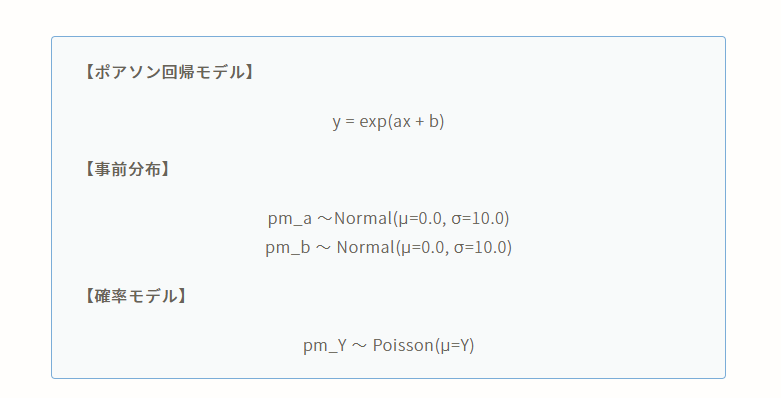

In [44]:
# ポアソン回帰モデルの設計
def model(X, Y=None):
    pm_a = numpyro.sample("pm_a", dist.Normal(0.0, 10.0))
    pm_b = numpyro.sample("pm_b", dist.Normal(0.0, 10.0))

    theta = pm_a * X + pm_b
    mu = jnp.exp(theta)

    numpyro.sample("pm_Y", dist.Poisson(mu), obs=Y)

In [45]:
# Run MCMC
kernel = NUTS(model)
# mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000, num_chains=4)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000)
mcmc.run(rng_key=random.PRNGKey(0), X=X, Y=Y)

# print MCMC summary（事後分布の基本統計量を確認）
mcmc.print_summary()

sample: 100%|██████████| 3000/3000 [00:00<00:00, 3858.36it/s, 15 steps of size 2.37e-01. acc. prob=0.94]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      pm_a      0.03      0.00      0.03      0.02      0.04    435.78      1.00
      pm_b      0.46      0.09      0.45      0.31      0.59    399.54      1.00

Number of divergences: 0


In [46]:
# get param (num_samples=2000)
mcmc_samples = mcmc.get_samples()
pm_a = mcmc_samples["pm_a"]
pm_b = mcmc_samples["pm_b"]

print("mcmc_samples:", mcmc_samples)
print("pm_a:", pm_a)
print("pm_b:", pm_b)

mcmc_samples: {'pm_a': Array([0.03003247, 0.0300827 , 0.02773185, ..., 0.03265581, 0.03095045,
       0.03059688], dtype=float32), 'pm_b': Array([0.5058282 , 0.5151023 , 0.5058284 , ..., 0.37341517, 0.4465436 ,
       0.42378387], dtype=float32)}
pm_a: [0.03003247 0.0300827  0.02773185 ... 0.03265581 0.03095045 0.03059688]
pm_b: [0.5058282  0.5151023  0.5058284  ... 0.37341517 0.4465436  0.42378387]


C:\Users\takuk\AppData\Local\Temp\ipykernel_27764\3318693772.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pm_a)
C:\Users\takuk\AppData\Local\Temp\ipykernel_27764\3318693772.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pm_b)


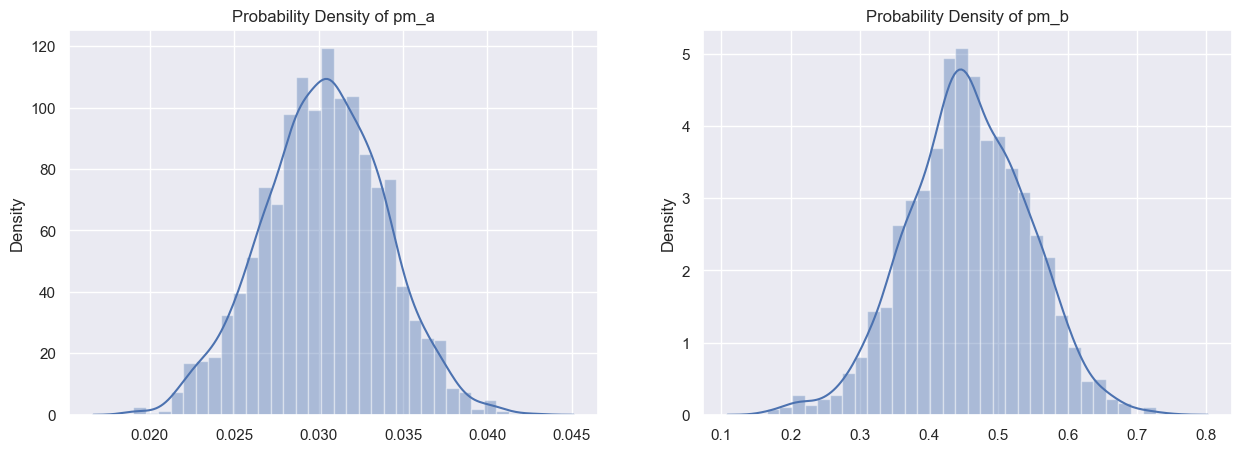

In [47]:
# 可視化
sns.set(style="darkgrid")
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.distplot(pm_a)
plt.title("Probability Density of pm_a")

plt.subplot(1, 2, 2)
sns.distplot(pm_b)
plt.title("Probability Density of pm_b")
plt.show()

### 推論

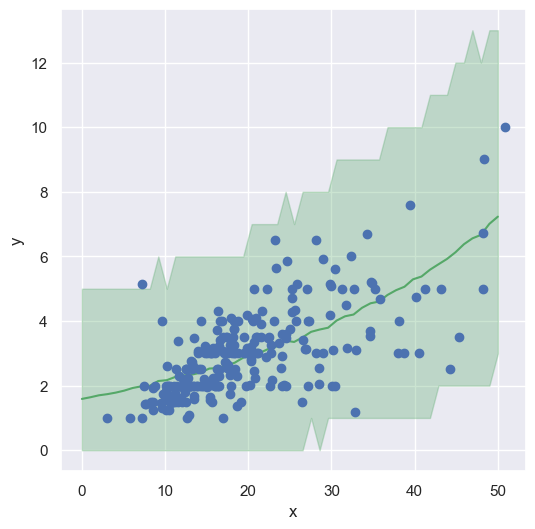

In [49]:
X_range = jnp.linspace(0, 50, 50)

predictive = Predictive(model, mcmc_samples)
predict_samples = predictive(random.PRNGKey(0), X=X_range, Y=None)
# print(predict_samples)

pm_Y = predict_samples["pm_Y"]
# print(pm_Y)

mean_Y = pm_Y.mean(axis=0)
y_low, y_high = jnp.percentile(pm_Y, jnp.array([2.5, 97.5]), axis=0)

# 可視化
fig = plt.figure(figsize=(6.0, 6.0))
plt.plot(X_range, mean_Y, "-", color="g")
plt.fill_between(X_range, y_low, y_high, color="g", alpha=0.3)
plt.plot(X, Y, "o")
plt.xlabel("x"), plt.ylabel("y")
plt.show()

### 全ての推定パラメータを使って推論

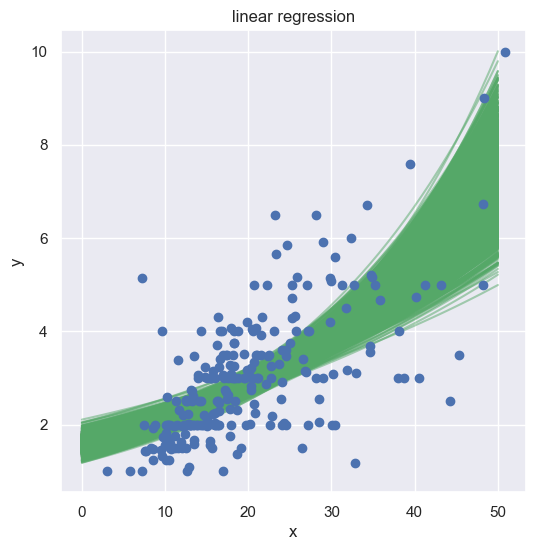

In [50]:
N = len(pm_a)
# X_range = jnp.linspace(0, 50, 50)

# 予測結果の可視化
fig = plt.figure(figsize=(6.0, 6.0))
for i in range(N):
    pm_y = [jnp.exp(pm_a[i] * x + pm_b[i]) for x in X_range]
    plt.plot(X_range, pm_y, "g-", alpha=0.5)

# データセットの可視化
plt.plot(X, Y, "o")
plt.xlabel("x"), plt.ylabel("y")
plt.title("linear regression")
plt.show()

mu_a= 0.030312581
mu_b= 0.45623016


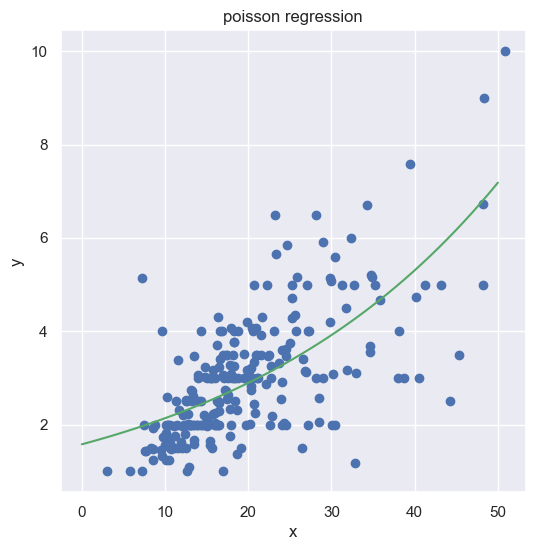

In [ ]:
def my_model(mcmc_samples, X):
    """ポアソン回帰モデル"""
    mcmc_samples = mcmc.get_samples()
    pm_a = mcmc_samples["pm_a"]
    pm_b = mcmc_samples["pm_b"]

    # 平均値
    mu_a = jnp.mean(pm_a, axis=0)
    mu_b = jnp.mean(pm_b, axis=0)
    print("mu_a=", mu_a)
    print("mu_b=", mu_b)

    # ポアソン回帰モデル
    Y_hat = jnp.exp(mu_a * X + mu_b)

    return Y_hat


# 予測値
Y_hat = my_model(mcmc_samples, X_range)

# 可視化
fig = plt.figure(figsize=(6.0, 6.0))
plt.plot(X, Y, "o")
plt.plot(X_range, Y_hat, "g-")
plt.xlabel("x"), plt.ylabel("y")
plt.title("poisson regression")
plt.show()